# Emotion Analysis using RNN


## 0. Instal Hugging Face's nlp Package

In [39]:
# !pip install nlp

## 1. Import the Libaries

In [40]:
import nlp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from datetime import datetime
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [41]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [42]:
# print(nlp.__version__)
# print(pd.__version__)
# print(np.__version__)
# print(tf.__version__)
# print()

In [43]:
# import streamlit as st
# print(st.__version__)

## 2. Import the Dataset & Visualize the Distributions

In [44]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [45]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [46]:
train = dataset['train']
train[20]

{'label': 'anger',
 'text': 'i feel irritated and rejected without anyone doing anything or saying anything'}

In [47]:
# Get lists of tweets & labels
def get_tweets(data):
    tweets = [d['text'] for d in data]
    labels = [d['label'] for d in data]
    return tweets, labels

tweets, labels = get_tweets(train)

In [48]:
# get classes
classes =   list(set(labels))
classes

['fear', 'love', 'anger', 'joy', 'surprise', 'sadness']

In [49]:
# Count each class
counts = [labels.count(c) for c in classes]
counts

[1937, 1304, 2159, 5362, 572, 4666]

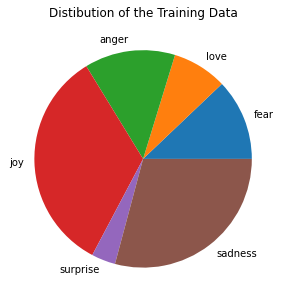

In [50]:
fig = plt.figure(figsize =(5,5))
plt.pie(counts, labels = classes)
plt.title('Distibution of the Training Data')
plt.show()

In [51]:
print('Attention: There is an inbalance in the dataset', ',which may cause issues in the predictions!')

Attention: There is an inbalance in the dataset ,which may cause issues in the predictions!


## 3. Relabel the Emotions in the Dataset

In [52]:
# convert the classes to nums =  [0,1,2,3,4,5]

nums_to_names = dict(enumerate(classes))
names_to_nums = {v:k for (k,v) in nums_to_names.items()}
nums_to_names, names_to_nums

({0: 'fear', 1: 'love', 2: 'anger', 3: 'joy', 4: 'surprise', 5: 'sadness'},
 {'fear': 0, 'love': 1, 'anger': 2, 'joy': 3, 'surprise': 4, 'sadness': 5})

In [53]:
def relabel_names_to_nums(names_to_nums, labels):
    new_labels = [names_to_nums[label]  for label in labels]     
    return new_labels

def load_datasets(data, names_to_nums):
    DATA_COLUMN = 'tweets'
    LABEL_COLUMN = 'labels'
    tweets, labels = get_tweets(data)
    new_labels = relabel_names_to_nums(names_to_nums, labels)
    dataframe = pd.DataFrame(list(zip(tweets, new_labels)),
               columns =[DATA_COLUMN, LABEL_COLUMN])
    return dataframe

In [54]:
test, val = dataset['test'], dataset['validation']

train_df = load_datasets(train, names_to_nums)
test_df = load_datasets(test, names_to_nums)
val_df = load_datasets(val, names_to_nums)

## 4. Get the Maximum Length of the Tweets

20000


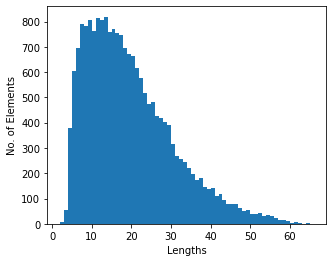

In [55]:
DATA_COLUMN = 'tweets'
LABEL_COLUMN = 'labels'
    
all_tweets = list(train_df[DATA_COLUMN]) + list(test_df[DATA_COLUMN]) + list(val_df[DATA_COLUMN])
lengths = [len(text.split(' ')) for text in all_tweets]
print(len(all_tweets))

fig = plt.figure(figsize = (5,4))
plt.hist(lengths, bins=len(set(lengths)))
plt.xlabel('Lengths')
plt.ylabel('No. of Elements')
plt.savefig('length_of_tweets.png')
plt.show()

In [56]:
max_length = (max(lengths)//10 +1)*10 
max(lengths), max_length

(66, 70)

## 5. Tokenize the Tweets & Pad Sequences

In [57]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(all_tweets)

print(tokenizer.texts_to_sequences([all_tweets[20]]))

[[2, 3, 497, 4, 548, 174, 260, 149, 163, 35, 369, 163]]


In [58]:
df_train = train_df.sample(frac =1)
df_test = test_df.sample(frac =1)
df_val = val_df.sample(frac =1)

In [59]:
def prepare_datasets(tokenizer, Dataframe):
    DATA_COLUMN = 'tweets'
    LABEL_COLUMN = 'labels'
    ### get_sequences
    tweets = list(Dataframe[DATA_COLUMN])
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_length, padding='post')
    ### get labels -- np.array
    labels = np.array(Dataframe[LABEL_COLUMN])
    #####
    return tweets, padded_sequences, labels

train_tweets, train_padded_sequences,  train_labels = prepare_datasets(tokenizer, df_train)
test_tweets, test_padded_sequences,  test_labels = prepare_datasets(tokenizer, df_test)
val_tweets, val_padded_sequences,  val_labels = prepare_datasets(tokenizer, df_val)

## 6. Create the Model

In [60]:
# 
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=max_length, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax'),
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 70, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trai

## 7. Train the Model

In [61]:
print(f'Beginning Training!', '\n')
current_time = datetime.now()

h = model.fit(
    train_padded_sequences, train_labels,
    validation_data=(val_padded_sequences, val_labels),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

print('\n', "Training took time ", datetime.now() - current_time)

Beginning Training! 

Epoch 1/15
500/500 [==============================] - 42s 68ms/step - loss: 1.3343 - accuracy: 0.4531 - val_loss: 0.8449 - val_accuracy: 0.7010
Epoch 2/15
500/500 [==============================] - 29s 57ms/step - loss: 0.6141 - accuracy: 0.7863 - val_loss: 0.5648 - val_accuracy: 0.7975
Epoch 3/15
500/500 [==============================] - 28s 57ms/step - loss: 0.3617 - accuracy: 0.8832 - val_loss: 0.5047 - val_accuracy: 0.8275
Epoch 4/15
500/500 [==============================] - 28s 56ms/step - loss: 0.2516 - accuracy: 0.9210 - val_loss: 0.4190 - val_accuracy: 0.8665
Epoch 5/15
500/500 [==============================] - 28s 56ms/step - loss: 0.1890 - accuracy: 0.9446 - val_loss: 0.4237 - val_accuracy: 0.8825
Epoch 6/15
500/500 [==============================] - 29s 58ms/step - loss: 0.1530 - accuracy: 0.9548 - val_loss: 0.4002 - val_accuracy: 0.8895
Epoch 7/15
500/500 [==============================] - 28s 57ms/step - loss: 0.1270 - accuracy: 0.9636 - val_loss: 

## 8. Plot the Training History

In [62]:
list(h.history.keys())

['loss', 'accuracy', 'val_loss', 'val_accuracy']

In [63]:
def plot_history(h):
    epochs = len(h.history['loss'])
    fig = plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1,epochs+1), h.history.get('accuracy'), 'b-o', label='Training')
    plt.plot(range(1,epochs+1), h.history.get('val_accuracy'), 'k-o', label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel('Accuracy', fontsize = 12)
    plt.title('Epochs Vs Accuracy' , fontsize = 16)
    plt.legend(fontsize = 11)


    plt.subplot(1, 2, 2)
    plt.plot(range(1,epochs+1), h.history.get('loss'), 'b-*', label='Training')
    plt.plot(range(1,epochs+1), h.history.get('val_loss'), 'k-*', label='Validation')
#     plt.ylim([0., 1.])
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel('Loss', fontsize = 12)
    plt.title('Epochs Vs Loss' , fontsize = 16)
    plt.legend(fontsize = 11)
    plt.savefig('Accuracy_Loss.png')
    plt.show()

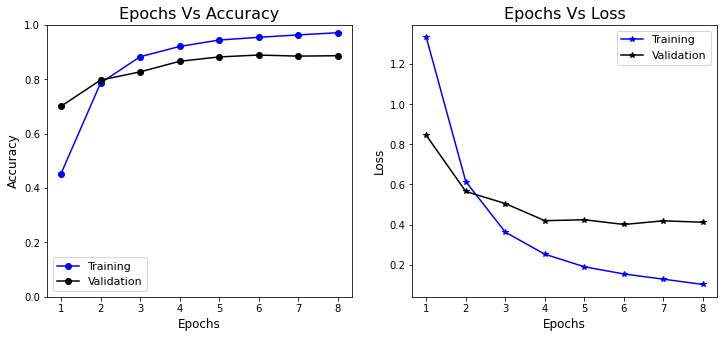

In [64]:
plot_history(h)

## 9. Evaluate the Model

In [65]:
eval = model.evaluate(test_padded_sequences, test_labels)

63/63 [==============================] - 2s 30ms/step - loss: 0.3746 - accuracy: 0.9030


In [66]:
def get_padded_sequences(pred_sentences, tokenizer):
    ### get_sequences
    sequences = tokenizer.texts_to_sequences(pred_sentences)
    ###
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_length, padding='post')    
    return padded_sequences

def predictions(pred_sentences):
    pred_sequences = get_padded_sequences(pred_sentences, tokenizer=tokenizer)
    predicts = model.predict(pred_sequences)
    classes=np.argmax(predicts, axis=-1)
    return  [(sentence, nums_to_names[class_]) for sentence, class_ in zip(pred_sentences, classes)]

In [67]:
# Radomly select # 5 # tweets from test_dataframe & predict 
num_to_select = 5

pred_samples = df_test.sample(num_to_select)
selected_sentences = list(pred_samples[DATA_COLUMN])

selected_label_nums = list(pred_samples[LABEL_COLUMN])
selected_labels = [nums_to_names[x] for x in selected_label_nums]

preds = predictions(selected_sentences)
preds

1/1 [==============================] - 7s 7s/step


[('i have been feeling regretful recently that i did not know back then that the abuse was not my fault and that it did not happen because of who i was but because of who they were',
  'sadness'),
 ('i think i love her enough now to feel pretty insulted and rawr about it',
  'anger'),
 ('i first read this book during college and it has helped me cope with the feeling of helplessness and fear of the uncertain future',
  'sadness'),
 ('i sometimes feel like a damaged product', 'sadness'),
 ('i didnt make it to my weight watchers meeting feeling guilty i made sure i had a healthy breakfast consisting of museli yoghurt and fruit',
  'sadness')]

In [68]:
predicted_labels = [v for (k,v) in preds]
predicted_labels, selected_labels

(['sadness', 'anger', 'sadness', 'sadness', 'sadness'],
 ['sadness', 'anger', 'fear', 'sadness', 'sadness'])

In [69]:
#  Predict the whole test_data
test_tweets, test_labels = get_tweets(test)
preds = predictions(test_tweets)
predicted_labels = [v for (k,v) in preds]

63/63 [==============================] - 1s 22ms/step


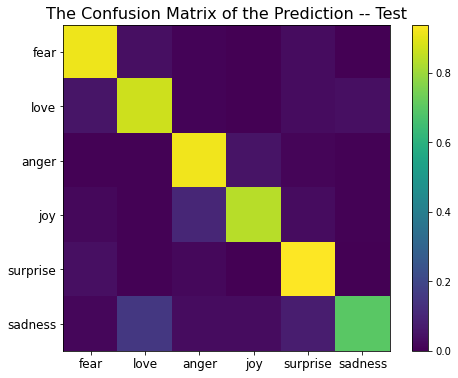

In [70]:
# Plot the confusion_matrix of the prediction

def plot_confusion_matrix(val_true, val_pred, classes):  
    
    cm = confusion_matrix(val_true, val_pred, normalize='true')
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    color_cm = ax.matshow(cm)
    
    plt.xticks(range(len(classes)), labels=classes, fontsize = 12)
    ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    plt.yticks(range(len(classes)), labels=classes, fontsize = 12)
    plt.colorbar(color_cm)
    plt.title('The Confusion Matrix of the Prediction -- Test' , fontsize = 16)
    plt.savefig('confusion_matrix_test.png')
    plt.show()
   
plot_confusion_matrix(test_labels, predicted_labels, classes)

## 10. Predict Inputs 

In [71]:
pred_sentences = [
  "That movie was absolutely awful!",
  "This is bloodly good",
  "The film was creative and surprising",
  "Absolutely fantastic!",
  "Go to the hell!",
  "You are so stupid!",
  "I don't belong here and must leave right now!"
]

In [72]:
preds = predictions(pred_sentences)
preds

1/1 [==============================] - 0s 41ms/step


[('That movie was absolutely awful!', 'sadness'),
 ('This is bloodly good', 'joy'),
 ('The film was creative and surprising', 'joy'),
 ('Absolutely fantastic!', 'joy'),
 ('Go to the hell!', 'anger'),
 ('You are so stupid!', 'sadness'),
 ("I don't belong here and must leave right now!", 'sadness')]

In [73]:
predicted_labels = [v for (k,v) in preds]
predicted_labels

['sadness', 'joy', 'joy', 'joy', 'anger', 'sadness', 'sadness']

## 11. Save & Reload the Trained Model

In [74]:
saved_model_path = 'HuggingFace_nlp_emotion_RNN'

In [75]:
model.save(saved_model_path)

INFO:tensorflow:Assets written to: HuggingFace_nlp_emotion_RNN\assets


INFO:tensorflow:Assets written to: HuggingFace_nlp_emotion_RNN\assets


In [76]:
reloaded_model = tf.keras.models.load_model(saved_model_path)

In [77]:
def reloaded_model_predictions(pred_sentences):
    pred_sequences = get_padded_sequences(pred_sentences, tokenizer=tokenizer)
#     print(pred_sequences)
    predicts = reloaded_model.predict(pred_sequences)
#     print(predicts)
    classes=np.argmax(predicts, axis=-1)
    return  [(sentence, nums_to_names[class_]) for sentence, class_ in zip(pred_sentences, classes)]

In [85]:
pred_sentences = [
  "That movie was absolutely awful!",
  "This is bloodly good",
  "The film was creative and surprising",
  "Absolutely fantastic!",
  "Go to hell!",
  "You are so stupid!",
  "I hate to say this",
  "I don't belong here and must leave right now!"
]

In [86]:
max_length = 70
preds = reloaded_model_predictions(pred_sentences)
preds

1/1 [==============================] - 0s 41ms/step


[('That movie was absolutely awful!', 'sadness'),
 ('This is bloodly good', 'joy'),
 ('The film was creative and surprising', 'joy'),
 ('Absolutely fantastic!', 'joy'),
 ('Go to hell!', 'anger'),
 ('You are so stupid!', 'sadness'),
 ('I hate to say this', 'sadness'),
 ("I don't belong here and must leave right now!", 'sadness')]

In [87]:
predicted_labels = [v for (k,v) in preds]
predicted_labels

['sadness', 'joy', 'joy', 'joy', 'anger', 'sadness', 'sadness', 'sadness']

In [81]:
nums_to_names

{0: 'fear', 1: 'love', 2: 'anger', 3: 'joy', 4: 'surprise', 5: 'sadness'}